In [1]:
import matplotlib.pyplot as plt
import numpy as np
import time

In [325]:
# Gauss-Seidel iterative solution of Ax=b
def gauss_seidel(A, b, x, tolerance=1e-10, max_iterations=10000):
    iter1 = 0
    for k in range(max_iterations):
        iter1 += 1   
        x_old  = x.copy()
        #Loop over rows
        for i in range(A.shape[0]):
            x[i] = (b[i] - np.dot(A[i,:i], x[:i]) - np.dot(A[i,(i+1):], x_old[(i+1):])) / A[i ,i]
        #Stop condition 
        if  max(abs((x - x_old)))/max(abs(x_old)) < tolerance:
            break
    #print("The L infinity norm in iteration", iter1,"is:", max(abs((x - x_old)))/max(abs(x_old)))       
    return x

# solve the linear system Ax=b
def solve_linear(A, b):
        #return np.linalg.solve(A, b)
        return gauss_seidel(A, b, -b)
        #return np.linalg.pinv(A).dot(b) 

### Advection/Convection Diffusion equation

$
\frac{\displaystyle \partial u}{\displaystyle \partial t} + \mathbf{v} \cdot \nabla u = \alpha\nabla^2 u + f 
$

where

$\nabla \cdot \mathbf{v} = 0$ (incompressible flow)


#### Courant–Friedrichs–Lewy number

$
CFL = \frac{\displaystyle v \Delta t}{\displaystyle \Delta x}  \hspace{0.5cm} \text{one dimentional}\\
CFL \le 1
$

#### Von Neumann stability condition (for explicit)

$
r = \frac{\displaystyle \alpha \Delta t}{\displaystyle (\Delta x)^2} \\
r \le \frac{\displaystyle 1}{\displaystyle 2}
$



In [529]:
# (solve Au=f for each time step) 

class AdvectionDiffusion: 
    """
    Finite difference solution of the Advection/Convection-Diffusion equation (parabolic and hyperbolic equation)

    Parameters
    ----------
    alpha: float
        Diffusivity in m*m/s    
    velocity: float
        Velocity in m/s
    dx: float
        Block size in meters
    N: int
        Number of blocks
    initial_condition: list (or numpy array) of floats
        Initial condition (one value per block -> size N)
    boundary_type: list (or numpy array) of str | default ['Dirichlet','Dirichlet']
        Left and right boundary condition type (options: 'Dirichlet', 'Neumann' or 'periodic'), e.g. ['Dirichlet','Neumann'] or ['periodic','periodic']  
    boundary_values: list (or numpy array) of floats | default [0., 0.]    
        Left and right boundary condition values, e.g. [10., -1.]
    time_integration: str | default 'implicit'
        Time integration (options: explict, implicit or Crank-Nicolson), e.g. 'implicit'
    space_discretization: str | default 'upwind'
        Space discretization (options: central or upwind), e.g. 'upwind'
    
    Methods
    -------
    forward(dt, source_term=None)
        Solve the transport equation for one time step of size dt considering the source term

    """  
    def __init__(self, alpha, velocity, dx, N, initial_condition, boundary_type = ['Dirichlet','Dirichlet'], boundary_values=[0, 0], time_integration='implicit', space_discretization='upwind'):   
        self.alpha = alpha
        self.velocity = velocity
        self.dx = dx 
        self.N = N  
        self.u_previous = np.array(initial_condition) # For the first time step
        self.boundary_type = boundary_type
        self.boundary_values = boundary_values
        self.time_integration = time_integration 
        self.space_discretization = space_discretization
        self.timestep_count = 0
        if time_integration == 'implicit' or time_integration == 'Crank-Nicolson':
            self.A = np.empty((N,N))
            self.f = np.empty(N)
        if space_discretization == 'upwind':
            self.w = 1. if velocity>0 else 0.
        elif space_discretization == 'central':
            self.w = 0.5
        else:
            print(f'Space discretization {self.space_discretization} NOT available!')   
    
    # Solve the heat equation explicitly  
    def solve_explicit(self, dt, source_term):
        
        # Define Courant–Friedrichs–Lewy number
        cfl = self.velocity*dt/self.dx
        
        # Define r
        r = self.alpha*dt/(self.dx*self.dx)
        
        # initialize u and add source term
        u = self.u_previous + dt*source_term
        
        #----------
        # Calculate advection and diffusion terms for elements not in the boundary
        #
        ## Advective term
        for i in range(1,self.N-1): 
            u[i] += -cfl*((self.u_previous[i+1]-self.u_previous[i])*(1-self.w)+(self.u_previous[i]-self.u_previous[i-1])*self.w)  
        ## Diffusive term
        for i in range(1,self.N-1):  
            u[i] += r*(self.u_previous[i-1]-2*self.u_previous[i]+self.u_previous[i+1])              
        
        #----------      
        # Calculate advection and diffusion terms for elements in the boundaries 
        #
        ## Left boundary
        if self.boundary_type[0] == 'Dirichlet':
            #
            ### Advective term 
            u[0] += -cfl*((self.u_previous[1]-self.u_previous[0])*(1-self.w)+(self.u_previous[0]-self.boundary_values[0])*self.w) 
            ### Diffusive term
            u[0] += r*(self.boundary_values[0]-2*self.u_previous[0]+self.u_previous[1])             
        elif self.boundary_type[0] == 'Neumann':
            #
            ### Advective term 
            u[0] += -cfl*((self.u_previous[1]-self.u_previous[0])*(1-self.w)+(self.dx*self.boundary_values[0])*self.w)   
            ### Diffusive term
            u[0] += r*(-self.dx*self.boundary_values[0]-self.u_previous[0]+self.u_previous[1]) 
        elif self.boundary_type[0] == 'periodic':
            #
            ### Advective term 
            u[0] += -cfl*((self.u_previous[1]-self.u_previous[0])*(1-self.w)+(self.u_previous[0]-self.u_previous[-1])*self.w)    
            ### Diffusive term
            u[0] += r*(self.u_previous[-1]-2*self.u_previous[0]+self.u_previous[1]) 
        else:
            print('Left boundary: no condition satisfaed!')    
        #
        ## Right boundary
        if self.boundary_type[1] == 'Dirichlet':
            #
            ### Advective term 
            u[-1] += -cfl*((self.boundary_values[-1]-self.u_previous[-1])*(1-self.w)+(self.u_previous[-1]-self.u_previous[-2])*self.w)       
            ### Diffusive term
            u[-1] += r*(self.u_previous[-2]-2*self.u_previous[-1]+self.boundary_values[-1]) 
        elif self.boundary_type[1] == 'Neumann':
            #
            ### Advective term             
            u[-1] += -cfl*((self.dx*self.boundary_values[-1])*(1-self.w)+(self.u_previous[-1]-self.u_previous[-2])*self.w)  
            ### Diffusive term
            u[-1] += r*(self.u_previous[-2]-self.u_previous[-1]+self.dx*self.boundary_values[-1])                 
        elif self.boundary_type[1] == 'periodic':
            #
            ### Advective term             
            u[-1] += -cfl*((self.u_previous[0]-self.u_previous[-1])*(1-self.w)+(self.u_previous[-1]-self.u_previous[-2])*self.w)    
            ### Diffusive term
            u[-1] += r*(self.u_previous[-2]-2*self.u_previous[-1]+self.u_previous[0])                 
        else:
            print('Left boundary: no condition satisfaed!')          
                       
        return u

    # Solve the heat equation fully implicit  
    def solve_implicit(self, dt, source_term):
        
        # Define Courant–Friedrichs–Lewy number
        cfl = self.velocity*dt/self.dx
        
        # Define r
        r = self.alpha*dt/(self.dx*self.dx)
        
        #----------
        # (Au=f) Calculate matrix A and f 
        #
        ## matrix A
        self.A[:] = np.diag([1]*self.N, 0)  # Main diagonal (identity)
        #
        ### Advective term 
        self.A += np.diag([-cfl*(1-self.w)+cfl*self.w]*self.N,  0)     # Main diagonal
        self.A += np.diag([cfl*(1-self.w)]*(self.N-1), 1)              # Upper diagonal
        self.A += np.diag([-cfl*self.w]*(self.N-1),-1)                 # Lower diagonal       
        #
        ### Diffusive term
        self.A += np.diag([2*r]*self.N,  0)      # Main diagonal
        self.A += np.diag([-r]*(self.N-1), 1)    # Upper diagonal
        self.A += np.diag([-r]*(self.N-1),-1)    # Lower diagonal  
        #
        ## Source term f
        self.f[:] = self.u_previous + dt*source_term            
        
        # ----------
        # Calculate boundary conditions 
        #
        ## Left boundary
        if self.boundary_type[0] == 'Dirichlet':
            #
            ### Advective term             
            self.f[0] += self.boundary_values[0]*cfl*self.w  
            ### Diffusive term      
            self.f[0] += self.boundary_values[0]*r 
        elif self.boundary_type[0] == 'Neumann':
            #
            ### Advective term               
            self.f[0]  += -self.boundary_values[0]*cfl*self.dx*self.w   
            self.A[0,0] += -cfl*self.w
            ### Diffusive term      
            self.f[0]  += -self.boundary_values[0]*r*self.dx   
            self.A[0,0] += -r                
        elif self.boundary_type[0] == 'periodic':
            #
            ### Advective term               
            self.A[0,-1] += -cfl*self.w  
            ### Diffusive term     
            self.A[0,-1] += -r                
        else:
            print('Left boundary: no condition satisfaed!')
        #
        ## Right boundary
        if self.boundary_type[1] == 'Dirichlet':
            #
            ### Advective term              
            self.f[-1] += -self.boundary_values[-1]*cfl*(1-self.w)
            ### Diffusive term     
            self.f[-1] += self.boundary_values[-1]*r
        elif self.boundary_type[1] == 'Neumann':
            #
            ### Advective term              
            self.f[-1] += -self.boundary_values[-1]*cfl*self.dx*(1-self.w)  
            self.A[-1,-1] += cfl*(1-self.w)
            ### Diffusive term     
            self.f[-1] += self.boundary_values[-1]*r*self.dx  
            self.A[-1,-1] += -r            
        elif self.boundary_type[1] == 'periodic':
            #
            ### Advective term              
            self.A[-1,0] += cfl*(1-self.w)
            ### Diffusive term     
            self.A[-1,0] += -r
        else:
            print('Right boundary: no condition satisfaed!')         
         
        # Calculate u from Au=f
        u = solve_linear(self.A, self.f)
        
        return u
    
    # Solve the heat equation using Crank-Nicolson (theta = 0 -> explicit, 1-> implicit)
    def solve_CrankNicolson(self, dt, source_term, theta=0.5):
        
        # Define Courant–Friedrichs–Lewy number
        cfl = self.velocity*dt/self.dx   
        
        # Define r
        r = self.alpha*dt/(self.dx*self.dx)        
        
        #----------
        # (Au=f) Calculate matrix A and f 
        #
        ## matrix A
        self.A[:] = np.diag([1]*self.N, 0)  # Main diagonal (identity)
        #
        ### Advective term         
        self.A += np.diag([-theta*cfl*(1-self.w)+theta*cfl*self.w]*self.N,  0)     # Main diagonal
        self.A += np.diag([theta*cfl*(1-self.w)]*(self.N-1), 1)                    # Upper diagonal
        self.A += np.diag([-theta*cfl*self.w]*(self.N-1),-1)                       # Lower diagonal    
        #
        ### Diffusive term       
        self.A += np.diag([2*r*theta]*self.N,  0)  # Main diagonal
        self.A += np.diag([-r*theta]*(self.N-1), 1)    # Upper diagonal
        self.A += np.diag([-r*theta]*(self.N-1),-1)    # Lower diagonal          
        #
        #
        ## Source term f
        self.f[:] = self.u_previous + dt*source_term
        ### Advective term    
        for i in range(1,self.N-1):
            self.f[i] += -(1-theta)*cfl*((self.u_previous[i+1]-self.u_previous[i])*(1-self.w)+(self.u_previous[i]-self.u_previous[i-1])*self.w) 
        ### Diffusive term       
        for i in range(1,self.N-1):
            self.f[i] += r*(1-theta)*(self.u_previous[i-1]-2*self.u_previous[i]+self.u_previous[i+1])        
        
        #----------
        # Calculate boundary conditions 
        #
        ## Left boundary
        if self.boundary_type[0] == 'Dirichlet':
            #
            ### Advective term               
            self.f[0] += -(1-theta)*cfl*((self.u_previous[1]-self.u_previous[0])*(1-self.w)+(self.u_previous[0]-self.boundary_values[0])*self.w)
            self.f[0] += theta*self.boundary_values[0]*cfl*self.w 
            ### Diffusive term         
            self.f[0] += (1-theta)*r*(self.boundary_values[0]-2*self.u_previous[0]+self.u_previous[1])
            self.f[0] += theta*r*self.boundary_values[0]            
        elif self.boundary_type[0] == 'Neumann':
            #
            ### Advective term               
            self.f[0] += -(1-theta)*cfl*((self.u_previous[1]-self.u_previous[0])*(1-self.w)+(self.dx*self.boundary_values[0])*self.w)
            self.f[0] += -theta*self.boundary_values[0]*cfl*self.dx*self.w 
            self.A[0,0] += -theta*cfl*self.w
            ### Diffusive term        
            self.f[0] += (1-theta)*r*(-self.dx*self.boundary_values[0]-self.u_previous[0]+self.u_previous[1])
            self.f[0] += -theta*self.dx*r*self.boundary_values[0]     
            self.A[0,0] += -r*theta
        elif self.boundary_type[0] == 'periodic':
            #
            ### Advective term               
            self.f[0] += -(1-theta)*cfl*((self.u_previous[1]-self.u_previous[0])*(1-self.w)+(self.u_previous[0]-self.u_previous[-1])*self.w)                
            self.A[0,-1] += -theta*cfl*self.w  
            ### Diffusive term   
            f[0] += (1-theta)*r*(self.u_previous[-1]-2*self.u_previous[0]+self.u_previous[1]) 
            self.A[0,-1] += -theta*r 
        else:
            print('Left boundary: no condition satisfaed!')
        #
        ## Right boundary
        if self.boundary_type[1] == 'Dirichlet':
            #
            ### Advective term              
            self.f[-1] += -(1-theta)*cfl*((self.boundary_values[-1]-self.u_previous[-1])*(1-self.w)+(self.u_previous[-1]-self.u_previous[-2])*self.w)
            self.f[-1] += -theta*self.boundary_values[-1]*cfl*(1-self.w)    
            ### Diffusive term   
            self.f[-1] += (1-theta)*r*(self.u_previous[-2]-2*self.u_previous[-1]+self.boundary_values[-1])
            self.f[-1] += theta*r*self.boundary_values[-1]            
        elif self.boundary_type[1] == 'Neumann':
            #
            ### Advective term              
            self.f[-1] += -(1-theta)*cfl*((self.dx*self.boundary_values[-1])*(1-self.w)+(self.u_previous[-1]-self.u_previous[-2])*self.w)
            self.f[-1] += -theta*self.boundary_values[-1]*cfl*self.dx*(1-self.w) 
            self.A[-1,-1] += theta*cfl*(1-self.w) 
            ### Diffusive term   
            self.f[-1] += (1-theta)*r*(self.u_previous[-2]-self.u_previous[-1]+self.dx*self.boundary_values[-1])
            self.f[-1] += self.dx*r*theta*self.boundary_values[-1] 
            self.A[-1,-1] += -r*theta            
        elif self.boundary_type[1] == 'periodic':
            #
            ### Advective term              
            self.f[-1] += -(1-theta)*cfl*((self.u_previous[0]-self.u_previous[-1])*(1-self.w)+(self.u_previous[-1]-self.u_previous[-2])*self.w)                
            self.A[-1,0] += theta*cfl*(1-self.w)   
            ### Diffusive term   
            self.f[-1] += (1-theta)*r*(self.u_previous[-2]-2*self.u_previous[-1]+self.u_previous[0])
            self.A[-1,0] += -theta*r            
        else:
            print('Right boundary: no condition satisfaed!')
          
        # Calculate u from Au=f
        u = solve_linear(self.A, self.f)
        
        return u 
    
            
    def forward(self, dt, source_term=None):
        """
        Solve the advection/convection-diffusion equation for one time step of size dt considering the source term
        
        
        Parameters
        ----------
        dt: float
            Time step size in seconds
        source_term: list (or numpy array) of floats | default None
            Source term (one value per block -> size N)
        
        Returns
        ----------
        u: numpy array of floats
            resulted field after time step dt (one value per block -> size N)

        """          
        source_term = np.array(self.N*[0]) if source_term == None else np.array(source_term)
        
        if self.time_integration == 'implicit':
            self.timestep_count += 1
            print(f'Time step {self.timestep_count} => dt = {dt}s, cfl = {self.velocity*dt/self.dx:.2f}, r = {self.alpha*dt/(self.dx*self.dx):.2f}, total time = {self.timestep_count*dt}s')
           
            u = self.solve_implicit(dt, source_term)
            self.u_previous[:] = u
            
        elif self.time_integration == 'Crank-Nicolson':
            self.timestep_count += 1
            print(f'Time step {self.timestep_count} => dt = {dt}s, cfl = {self.velocity*dt/self.dx:.2f}, r = {self.alpha*dt/(self.dx*self.dx):.2f}, total time = {self.timestep_count*dt}s')
          
            u = self.solve_CrankNicolson(dt, source_term, theta=0.5)
            self.u_previous[:] = u            
        
        elif self.time_integration == 'explicit':
            self.timestep_count += 1
            print(f'Time step {self.timestep_count} => dt = {dt}s, cfl = {self.velocity*dt/self.dx:.2f}{"(***WARNING cfl>1)" if self.velocity*dt/self.dx > 1.0 else ""}, r = {self.alpha*dt/(self.dx*self.dx):.2f}{"(***WARNING r>=1/2)" if self.alpha*dt/(self.dx*self.dx) >= 0.5 else ""}, total time = {self.timestep_count*dt}s')
           
            u = self.solve_explicit(dt, source_term)
            self.u_previous[:] = u
            
        else:
            print(f'Time integration {self.time_integration} NOT available!')
            return None
        
        return u

### Solve implicit

In [544]:
transport = AdvectionDiffusion(alpha=0.001,
            velocity = 0.1, 
            dx=0.1,
            N=11, #110 
            initial_condition =  4*[10.]+3*[0.]+4*[0.], #np.sin(np.linspace(0,2*np.pi,110,endpoint=False)), 
            #boundary_type = ['Dirichlet','Neumann'], 
            #boundary_type = ['Dirichlet','Dirichlet'], 
            boundary_type = ['Neumann','Neumann'], 
            #boundary_type = ['periodic','periodic'], 
            boundary_values = [0, 0],
            time_integration='implicit',
            space_discretization='upwind')

In [545]:
# Initialize u
u=[]
u.append(transport.u_previous.copy())  # Initial condition

Time step 1 => dt = 0.5s, cfl = 0.50, r = 0.05, total time = 0.5s
Time step 2 => dt = 0.5s, cfl = 0.50, r = 0.05, total time = 1.0s
Time step 3 => dt = 0.5s, cfl = 0.50, r = 0.05, total time = 1.5s
Time step 4 => dt = 0.5s, cfl = 0.50, r = 0.05, total time = 2.0s
Time step 5 => dt = 0.5s, cfl = 0.50, r = 0.05, total time = 2.5s
0.007323026657104492


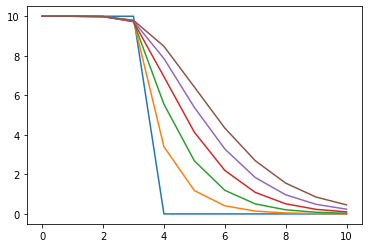

In [546]:
start = time.time()
for _ in range(5):
    u.append(transport.forward(dt=0.5, # seconds
                               #source_term=1*[0.]+9*[0.]+1*[0.]
                               )
            )
print(time.time()-start)
plt.plot(np.transpose(u));
u_imp = u

A = 
 [[ 1.05 -0.05  0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [-0.55  1.6  -0.05  0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.   -0.55  1.6  -0.05  0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.   -0.55  1.6  -0.05  0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.   -0.55  1.6  -0.05  0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.   -0.55  1.6  -0.05  0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.   -0.55  1.6  -0.05  0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.   -0.55  1.6  -0.05  0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.   -0.55  1.6  -0.05  0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.   -0.55  1.6  -0.05]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.   -0.55  1.55]]

u = 
 [9.99981143 9.99861838 9.98150171 9.79409177 8.48142616 6.41975467
 4.34528106 2.69321184 1.55743441 0.85259457 0.45664892]

f = 
 [9.99987108 9.99881803 9.98145804 9.75664958 7.86254365 5.38955904
 3.28692404 1.84136264 0.9679

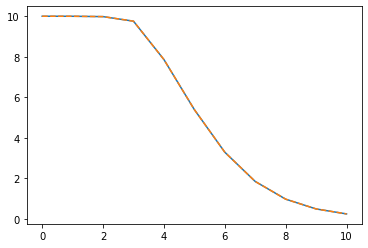

In [547]:
print('A = \n', transport.A)
print()
print('u = \n', u[-1])
print()
print('f = \n', transport.f)
print()
print('Determinant =', np.linalg.det(transport.A))
print('Error = ', np.max(abs(transport.A.dot(u[-1])-transport.f)))

plt.plot(transport.A.dot(u[-1]))
plt.plot(transport.f, '--')

[9.99981143 9.99861838 9.98150171 9.79409177 8.48142616 6.41975467
 4.34528106 2.69321184 1.55743441 0.85259457 0.45664892]


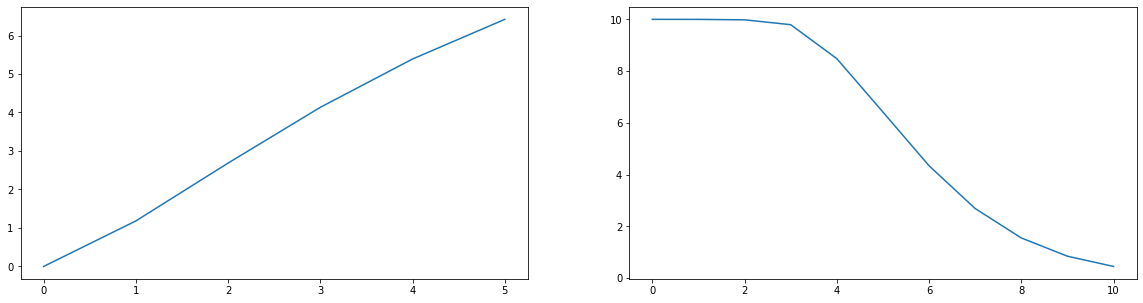

In [548]:
print(u_imp[-1])
fig, axes = plt.subplots(1,2, figsize=(20,5))
axes[0].plot(np.array(u_imp)[:,5])
axes[1].plot(u_imp[-1])

### Solve explicit

In [549]:
transport = AdvectionDiffusion(alpha=0.001,
            velocity = 0.1, 
            dx=0.1,
            N=11, #110
            initial_condition = 4*[10.]+3*[0.]+4*[0.], #np.sin(np.linspace(0,2*np.pi,110,endpoint=False)),
            #boundary_type = ['Dirichlet','Neumann'], 
            #boundary_type = ['Dirichlet','Dirichlet'], 
            boundary_type = ['Neumann','Neumann'], 
            #boundary_type = ['periodic','periodic'], 
            boundary_values = [0, 0],
            time_integration='explicit',
            space_discretization='upwind')

In [550]:
# Initialize u
u=[]
u.append(transport.u_previous.copy())  # Initial condition

Time step 1 => dt = 0.5s, cfl = 0.50, r = 0.05, total time = 0.5s
Time step 2 => dt = 0.5s, cfl = 0.50, r = 0.05, total time = 1.0s
Time step 3 => dt = 0.5s, cfl = 0.50, r = 0.05, total time = 1.5s
Time step 4 => dt = 0.5s, cfl = 0.50, r = 0.05, total time = 2.0s
Time step 5 => dt = 0.5s, cfl = 0.50, r = 0.05, total time = 2.5s
0.0007405281066894531


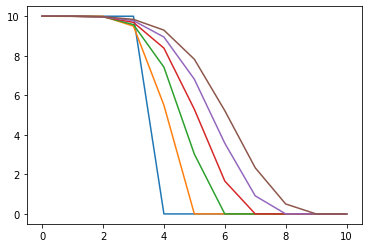

In [551]:
start = time.time()
for _ in range(5):
    u.append(transport.forward(dt=0.5, # seconds
                               #source_term=4*[0.]+3*[0.]+4*[0.]
                               )
            )
print(time.time()-start)
plt.plot(np.transpose(u));
u_exp = u

[9.9998375  9.9977     9.9762     9.84241875 9.29726875 7.825675
 5.224175   2.33340938 0.50328437 0.         0.        ]
[9.99981143 9.99861838 9.98150171 9.79409177 8.48142616 6.41975467
 4.34528106 2.69321184 1.55743441 0.85259457 0.45664892]


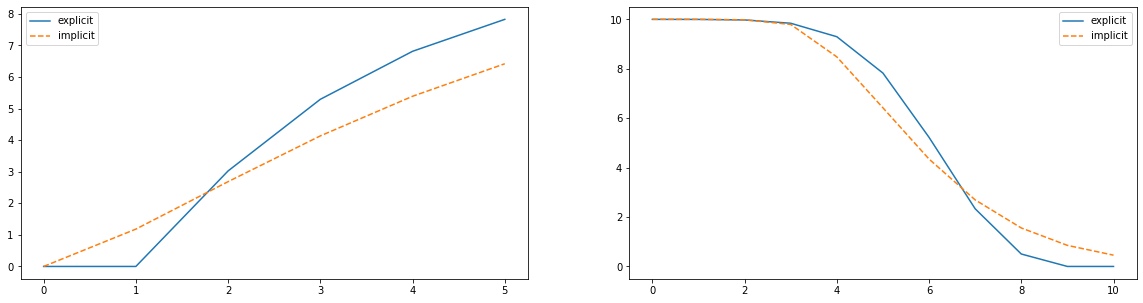

In [552]:
print(u_exp[-1])
print(u_imp[-1])
fig, axes = plt.subplots(1,2, figsize=(20,5))
axes[0].plot(np.array(u_exp)[:,5])
axes[0].plot(np.array(u_imp)[:,5],'--')
axes[0].legend(['explicit','implicit'])
axes[1].plot(u_exp[-1])
axes[1].plot(u_imp[-1],'--')
axes[1].legend(['explicit','implicit'])

### Solve Crank-Nicolson

In [553]:
transport = AdvectionDiffusion(alpha=0.001,
            velocity = 0.1, 
            dx=0.1,
            N=11, #110 
            initial_condition = 4*[10.]+3*[0.]+4*[0.], #np.sin(np.linspace(0,2*np.pi,110,endpoint=False)), 
            #boundary_type = ['Dirichlet','Neumann'], 
            #boundary_type = ['Dirichlet','Dirichlet'], 
            boundary_type = ['Neumann','Neumann'], 
            #boundary_type = ['periodic','periodic'], 
            boundary_values = [0, 0],
            time_integration='Crank-Nicolson',
            space_discretization='upwind')

In [554]:
# Initialize u
u=[]
u.append(transport.u_previous.copy())  # Initial condition

Time step 1 => dt = 0.5s, cfl = 0.50, r = 0.05, total time = 0.5s
Time step 2 => dt = 0.5s, cfl = 0.50, r = 0.05, total time = 1.0s
Time step 3 => dt = 0.5s, cfl = 0.50, r = 0.05, total time = 1.5s
Time step 4 => dt = 0.5s, cfl = 0.50, r = 0.05, total time = 2.0s
Time step 5 => dt = 0.5s, cfl = 0.50, r = 0.05, total time = 2.5s
0.006757020950317383


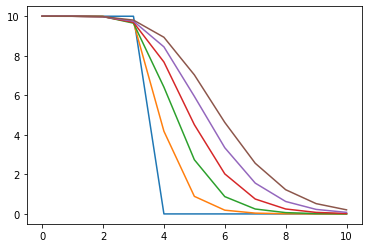

In [555]:
start = time.time()
for _ in range(5):
    u.append(transport.forward(dt=0.5, # seconds
                               #source_term=1*[0.]+9*[0.]+1*[0.]
                               )
            )
print(time.time()-start)
plt.plot(np.transpose(u));
u_cn = u

A = 
 [[ 1.025 -0.025  0.     0.     0.     0.     0.     0.     0.     0.
   0.   ]
 [-0.275  1.3   -0.025  0.     0.     0.     0.     0.     0.     0.
   0.   ]
 [ 0.    -0.275  1.3   -0.025  0.     0.     0.     0.     0.     0.
   0.   ]
 [ 0.     0.    -0.275  1.3   -0.025  0.     0.     0.     0.     0.
   0.   ]
 [ 0.     0.     0.    -0.275  1.3   -0.025  0.     0.     0.     0.
   0.   ]
 [ 0.     0.     0.     0.    -0.275  1.3   -0.025  0.     0.     0.
   0.   ]
 [ 0.     0.     0.     0.     0.    -0.275  1.3   -0.025  0.     0.
   0.   ]
 [ 0.     0.     0.     0.     0.     0.    -0.275  1.3   -0.025  0.
   0.   ]
 [ 0.     0.     0.     0.     0.     0.     0.    -0.275  1.3   -0.025
   0.   ]
 [ 0.     0.     0.     0.     0.     0.     0.     0.    -0.275  1.3
  -0.025]
 [ 0.     0.     0.     0.     0.     0.     0.     0.     0.    -0.275
   1.275]]

u = 
 [9.99982043 9.99831652 9.97845332 9.80547285 8.93697789 7.03409693
 4.62801515 2.56228186 1.22491817 0.5208072

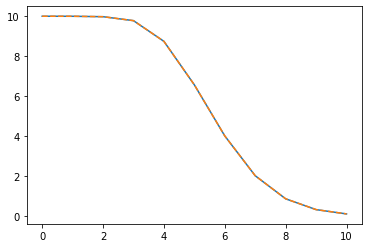

In [556]:
print('A = \n', transport.A)
print()
print('u = \n', u[-1])
print()
print('f = \n', transport.f)
print()
print('Determinant =', np.linalg.det(transport.A))
print('Error = ', np.max(abs(transport.A.dot(u[-1])-transport.f)))

plt.plot(transport.A.dot(u[-1]))
plt.plot(transport.f, '--')

[9.9998375  9.9977     9.9762     9.84241875 9.29726875 7.825675
 5.224175   2.33340938 0.50328437 0.         0.        ]
[9.99981143 9.99861838 9.98150171 9.79409177 8.48142616 6.41975467
 4.34528106 2.69321184 1.55743441 0.85259457 0.45664892]
[9.99982043 9.99831652 9.97845332 9.80547285 8.93697789 7.03409693
 4.62801515 2.56228186 1.22491817 0.52080729 0.2063147 ]


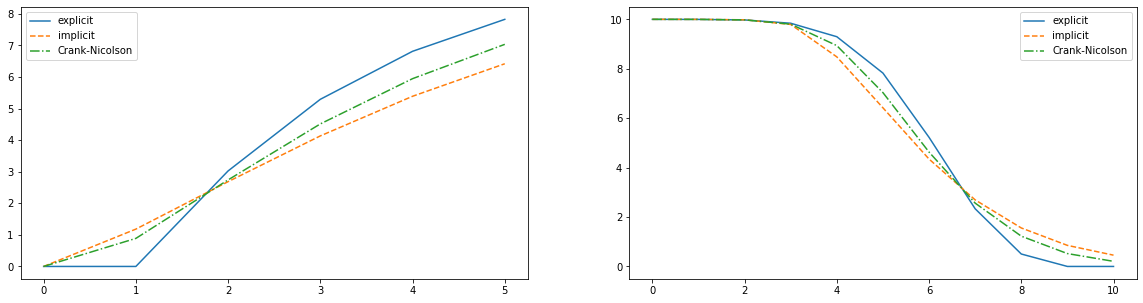

In [557]:
print(u_exp[-1])
print(u_imp[-1])
print(u_cn[-1])
fig, axes = plt.subplots(1,2, figsize=(20,5))
axes[0].plot(np.array(u_exp)[:,5])
axes[0].plot(np.array(u_imp)[:,5],'--')
axes[0].plot(np.array(u_cn)[:,5],'-.')
axes[0].legend(['explicit','implicit','Crank-Nicolson'])
axes[1].plot(u_exp[-1])
axes[1].plot(u_imp[-1],'--')
axes[1].plot(u_cn[-1],'-.')
axes[1].legend(['explicit','implicit','Crank-Nicolson'])